In [26]:
import sys
import networkx as nx
import matplotlib as plt
import numpy as np
import re
import chess
import subprocess
import timeit
import pickle
import stockfish
from stockfish import Stockfish
import chess
import chess.engine

engine = chess.engine.SimpleEngine.popen_uci("../stockfish-10-64")
stockfish = Stockfish("../stockfish-10-64")

In [27]:
def varWeighted(scores, counts):
    if (len(counts)<2):
        return None
    else:
        weightedMean = sum([a*b for a,b in zip(scores,counts)])/sum(counts)
        scoreDiffs = [(score - weightedMean)**2 for score in scores]
        V1 = sum(counts)
        V2 = sum([count**2 for count in counts])
        var = (V1/(V1**2-V2)) * sum([a*b for a,b in zip(counts,scoreDiffs)])
        return var
    
def get_score(san):
    board = chess.Board()
    for move in san:
        board.push_san(move)
    currFen = board.fen()
    score = engine.analyse(board, chess.engine.Limit(time=.05), info=chess.engine.INFO_SCORE)
    if('#' in str(score['score'])):
        if('-' in str(score['score'])):
            return -39765
        else:
            return 39765
    else:
        score = int(str(score["score"]))
    return score

def san_to_fen(san):
    board = chess.Board()
    for move in san:
        board.push_san(move)
    currFen = board.fen()
    return currFen

def get_node_sd(node):
    scores = []
    counts = []
    try:
        for neighbor in list(g.neighbors(node)):
            scores.append(nx.get_node_attributes(g, 'score')[neighbor])
            counts.append(nx.get_node_attributes(g, 'movelistCount')[neighbor][node])
        return node, np.sqrt(varWeighted(scores,counts))
    except:
        return node, None

In [28]:
game_file = "../tab-trunc.txt"

with open(game_file, "r") as file_in:
    mainlineList = []
    for line in file_in:
        mainlineList.append(line)

#extract each string of moves
stringList = []
for mainLine in mainlineList:
    stringList.append(mainLine.split())

# stringList.sort(key = len) 


In [29]:
print(len(stringList))

94975


In [5]:
#Move ['32', 'f3', 'e5', 'g4', 'Qh4#']

board = chess.Board()
board.push_san('f3') #push the move to the board
board.push_san('e5') #push the move to the board
#board.push_san('g4') #push the move to the board
#board.push_san('Qh4#') #push the move to the board
currFen = board.fen()
print(currFen)
stockfish.set_fen_position(currFen)
score = stockfish.get_evaluation()['value']
print(score)

rnbqkbnr/pppp1ppp/8/4p3/8/5P2/PPPPP1PP/RNBQKBNR w KQkq - 0 2
-101


In [34]:
cnt = 0
start = timeit.default_timer()

#initialize graph with root node
g = nx.DiGraph()
g.add_node('root', score = 0, movelist = 'root')

for s in stringList:
    whiteMove = 1
    if(cnt%1000 == 0):
        print("strings processed:", cnt, "TIME:", timeit.default_timer()-start)
    count = int(s[0])
    if(count >= 30):
        board = chess.Board()
        parentFen = 'root'
        try:
            for move in s[1:]:
                san = s[1:s.index(move)]
                board.push_san(move)
                currFen = board.fen()
                if(currFen not in g.nodes):
                    board = chess.Board(currFen)
                    if('#' not in move):
                        score = engine.analyse(board, chess.engine.Limit(time=0.05))
                        if('#' in str(score['score'])):
                            if('-' in str(score['score'])):
                                score =  -39765
                            else:
                                score =  39765
                        else:
                            score = int(str(score["score"])) * whiteMove
    #                         stockfish.set_fen_position(currFen)
    #                         score = stockfish.get_evaluation()['value']
                    else:
                        score = -39765 * whiteMove
                    g.add_node(currFen,
                               score = score,
                               count = count,
                               san = san,
                               movelistCount = {parentFen:count})
                    g.add_edge(parentFen, currFen)
                else:
                    if(parentFen in nx.get_node_attributes(g, 'movelistCount')[currFen]):
                        nx.get_node_attributes(g, 'movelistCount')[currFen][parentFen] += count #increase parent count
                    else:
                        nx.get_node_attributes(g, 'movelistCount')[currFen][parentFen] = count #add parent and count
                        g.add_edge(parentFen, currFen) #add edge from parentFen to currFen
                    g.nodes[currFen]['count'] = nx.get_node_attributes(g, 'count')[currFen] + count #increase count
    #                 whiteMove *= -1
                parentFen = currFen
        except Exception as e:
            print(e)
            print(sys.exc_info()[0])
            print("Move",s)
            stockfish.set_fen_position(currFen)
            print(stockfish.get_evaluation()['value'])
            break
        cnt+=1
    else:
        cnt+=1
            
stop = timeit.default_timer()
print('Time: ', stop - start)
print("totalNodes:",len(g))

strings processed: 0 TIME: 0.0020262219995856867
strings processed: 1000 TIME: 11.16147652499967
strings processed: 2000 TIME: 17.09509984000033
strings processed: 3000 TIME: 22.890486051000153
strings processed: 4000 TIME: 28.192998923000232
strings processed: 5000 TIME: 32.83378207500027
strings processed: 6000 TIME: 34.95174727799986
strings processed: 7000 TIME: 39.608978260000185
strings processed: 8000 TIME: 45.84379090600032
strings processed: 9000 TIME: 52.71641292200002
strings processed: 10000 TIME: 58.37509408599999
strings processed: 11000 TIME: 65.01126409500012
strings processed: 12000 TIME: 69.55499115800012
strings processed: 13000 TIME: 75.75119056400035
strings processed: 14000 TIME: 81.19541485399986
strings processed: 15000 TIME: 87.64105325000037
strings processed: 16000 TIME: 93.48725752799965
strings processed: 17000 TIME: 99.21751640300045
strings processed: 18000 TIME: 106.53843234499982
strings processed: 19000 TIME: 112.03005860699977
strings processed: 20000

In [35]:
g.nodes()['rnbqkbnr/pppppppp/8/8/8/2N5/PPPPPPPP/R1BQKBNR b KQkq - 1 1']

{'score': 55, 'count': 1717, 'san': [], 'movelistCount': {'root': 1717}}

In [36]:
#nx.write_gpickle(g,"test.gpickle")

In [37]:
g = nx.read_gpickle('full94k.gpickle')

In [38]:
start = timeit.default_timer()

board = chess.Board()
board.push_san('d4') #push the move to the board
board.push_san('Nf6') #push the move to the board
currFen = board.fen()
print(currFen)
scores = []
counts = []
for neighbor in list(g.neighbors(currFen)):
    scores.append(nx.get_node_attributes(g, 'score')[neighbor])
    counts.append(nx.get_node_attributes(g, 'count')[neighbor])
    
print("sd:",np.sqrt(varWeighted(scores, counts)))

stop = timeit.default_timer()
print('Time: ', stop - start) 

rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 1 2
sd: 30.45809202325837
Time:  0.18885231999956886


In [39]:
gamesDict = {"root" : ['e4', 'c5'],
"safe" : ['e4', 'c5', 'c3'],
"risky" : ['e4', 'c5', 'd4'],
"root2" : ['e4', 'e6', 'd4', 'd5'],
"popular2.0" : ['e4', 'e6', 'd4', 'd5', 'Nc3'],
"popular2.1" : ['e4', 'e6', 'd4', 'd5', 'Nd2'],
"safe2" : ['e4', 'e6', 'd4', 'd5', 'exd5'],
"risky2" : ['e4', 'e6', 'd4', 'd5', 'e5'],
"Ruy" : ['e4', 'e5','Nf3', 'Nc6','Bb5'],
"Vienna" : ['e4' ,'e5','d4','exd4','c3']}

for key, game in gamesDict.items():
    currFen = san_to_fen(game)
    scores = []
    counts = []
    try:
        for neighbor in list(g.neighbors(currFen)):
            scores.append(nx.get_node_attributes(g, 'score')[neighbor])
            counts.append(nx.get_node_attributes(g, 'movelistCount')[neighbor][currFen])
        print('{} {} ||| SD :'.format(key, game), np.sqrt(varWeighted(scores,counts)), ", total Games:", sum(counts))
    except:
        break

    

root ['e4', 'c5'] ||| SD : 43.00324464039583 , total Games: 28705
safe ['e4', 'c5', 'c3'] ||| SD : 36.879722262305535 , total Games: 1026
risky ['e4', 'c5', 'd4'] ||| SD : 109.85630879333112 , total Games: 2772
root2 ['e4', 'e6', 'd4', 'd5'] ||| SD : 31.477399439383305 , total Games: 4964
popular2.0 ['e4', 'e6', 'd4', 'd5', 'Nc3'] ||| SD : 39.448541755734425 , total Games: 874
popular2.1 ['e4', 'e6', 'd4', 'd5', 'Nd2'] ||| SD : 65.85793190255994 , total Games: 241
safe2 ['e4', 'e6', 'd4', 'd5', 'exd5'] ||| SD : 41.7193000900063 , total Games: 1450
risky2 ['e4', 'e6', 'd4', 'd5', 'e5'] ||| SD : 85.08457934720629 , total Games: 2668
Ruy ['e4', 'e5', 'Nf3', 'Nc6', 'Bb5'] ||| SD : 27.72962086948965 , total Games: 3926
Vienna ['e4', 'e5', 'd4', 'exd4', 'c3'] ||| SD : 47.20393825748048 , total Games: 1028


In [40]:
sd_dict = {}
for node in g.nodes():
    n, val = get_node_sd(node)
    sd_dict.update({n: val})
#     dict.update(Iterable_Sequence of key:value)
#     sd_list.append(get_node_sd(node))

sd_dict = {key:val for key, val in sd_dict.items() if val != None}

maxSD = max(sd_dict.items(), key=lambda x : x[1])
print('Max value in Dict: ', maxSD[1])
print('Key With Max value in Dict: ', maxSD[0])

Max value in Dict:  24592.514181645995
Key With Max value in Dict:  rnbqkbnr/pppp1ppp/8/4p3/8/5P2/PPPPP1PP/RNBQKBNR w KQkq - 0 2


In [41]:
{k: v for k, v in sorted(sd_dict.items(), key=lambda item: item[1], reverse = True)}

{'rnbqkbnr/pppp1ppp/8/4p3/8/5P2/PPPPP1PP/RNBQKBNR w KQkq - 0 2': 24592.514181645995,
 'rnbqkbnr/ppppp1pp/5p2/8/3PP3/8/PPP2PPP/RNBQKBNR b KQkq - 0 2': 17179.885812972832,
 'r1bqkbnr/pppp1p1p/2n3p1/4p3/2B1P3/5Q2/PPPP1PPP/RNB1K1NR b KQkq - 1 4': 16871.401128992016,
 'rnbqkbnr/ppp2ppp/3p4/4p2Q/2B1P3/8/PPPP1PPP/RNB1K1NR b KQkq - 1 3': 15180.862085440618,
 'r1bqkbnr/pppp1ppp/2n5/4p2Q/2B1P3/8/PPPP1PPP/RNB1K1NR b KQkq - 3 3': 14719.963822688587,
 'rnbqkbnr/pppp1ppp/8/4p2Q/4P3/8/PPPP1PPP/RNB1KBNR b KQkq - 1 2': 5249.401375353206,
 'r1b1kbnr/pppp1ppp/8/4N1q1/2BnP3/8/PPPP1PPP/RNBQK2R w KQkq - 1 5': 544.4722215136416,
 'rnbqkbnr/pppppp1p/6p1/8/8/1P6/PBPPPPPP/RN1QKBNR b KQkq - 1 2': 523.5188862479148,
 'r1bqkbnr/pppp1ppp/2n5/8/4P3/2Q5/PPP2PPP/RNB1KBNR b KQkq - 2 4': 499.2173875177026,
 'rnb1kbnr/ppp1pppp/2q5/8/8/2N5/PPPP1PPP/R1BQKBNR w KQkq - 2 4': 487.9036790187178,
 'rnbq1bnr/pppp1kpp/8/4Q3/2B1P3/8/PPPP1PPP/RNB1K2R b KQ - 2 6': 409.414826307011,
 'r1bqkbnr/pppp1pp1/2n4p/4p3/2BPP3/5N2/PPP2PPP/RNBQ

In [78]:
currFen = 'r1b1kbnr/pppp1ppp/8/4N1q1/2BnP3/8/PPPP1PPP/RNBQK2R w KQkq - 1 5'
scores = []
counts = []

for neighbor in list(g.neighbors(currFen)):
    print(neighbor, g.nodes()[neighbor])
    scores.append(nx.get_node_attributes(g, 'score')[neighbor])
    counts.append(nx.get_node_attributes(g, 'movelistCount')[neighbor][currFen])
print('SD :', np.sqrt(varWeighted(scores,counts)), ", total Games:", sum(counts))


r1b1kbnr/pppp1Npp/8/6q1/2BnP3/8/PPPP1PPP/RNBQK2R b KQkq - 0 5 {'score': 778, 'count': 107, 'san': ['e4', 'e5', 'Nf3', 'Nc6', 'Bc4', 'Nd4', 'Nxe5', 'Qg5'], 'movelistCount': {'r1b1kbnr/pppp1ppp/8/4N1q1/2BnP3/8/PPPP1PPP/RNBQK2R w KQkq - 1 5': 107}}
r1b1kbnr/pppp1Bpp/8/4N1q1/3nP3/8/PPPP1PPP/RNBQK2R b KQkq - 0 5 {'score': 8, 'count': 32, 'san': ['e4', 'e5', 'Nf3', 'Nc6', 'Bc4', 'Nd4', 'Nxe5', 'Qg5'], 'movelistCount': {'r1b1kbnr/pppp1ppp/8/4N1q1/2BnP3/8/PPPP1PPP/RNBQK2R w KQkq - 1 5': 32}}
SD : 544.4722215136416 , total Games: 139


{'depth': 16, 'seldepth': 26, 'multipv': 1, 'score': PovScore(Cp(+61), WHITE), 'nodes': 68765, 'nps': 1348333, 'tbhits': 0, 'time': 0.051}


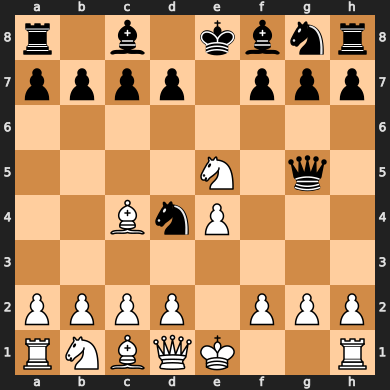

In [79]:
board = chess.Board(currFen)
print(engine.analyse(board, chess.engine.Limit(time=.05), info=chess.engine.INFO_SCORE))
board

{'depth': 15, 'seldepth': 22, 'multipv': 1, 'score': PovScore(Cp(+806), BLACK), 'nodes': 95419, 'nps': 1870960, 'tbhits': 0, 'time': 0.051}


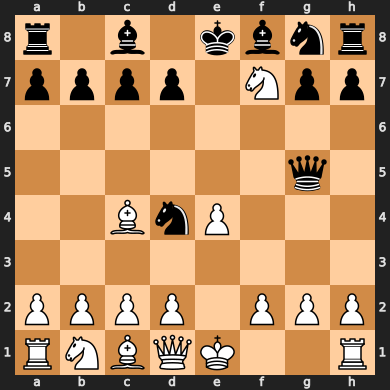

In [81]:
board = chess.Board('r1b1kbnr/pppp1Npp/8/6q1/2BnP3/8/PPPP1PPP/RNBQK2R b KQkq - 0 5')
print(engine.analyse(board, chess.engine.Limit(time=.05), info=chess.engine.INFO_SCORE))
board

{'depth': 16, 'seldepth': 22, 'multipv': 1, 'score': PovScore(Cp(-2), BLACK), 'nodes': 64296, 'nps': 1260705, 'tbhits': 0, 'time': 0.051}


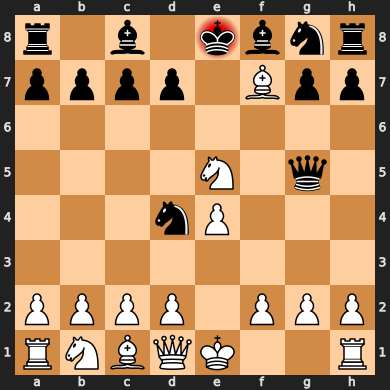

In [84]:
board = chess.Board('r1b1kbnr/pppp1Bpp/8/4N1q1/3nP3/8/PPPP1PPP/RNBQK2R b KQkq - 0 5')
print(engine.analyse(board, chess.engine.Limit(time=.05), info=chess.engine.INFO_SCORE))
board